In [7]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import sys
import glob
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
from torch import nn

In [9]:
sys.path.append('../../')

In [10]:
# Check if we are on the GPU or not
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

False
cpu


# Pretrain

In [11]:
# Model Hyperparameters
root_path = [
    # EE_EEE
    ['../data/sets/EE_EEE/A1E5.A2E5.B1E5.B2E5.B3E5/processed01_torch/',
     '../data/sets/EE_EEE/preprocessing/EE_EEE_labels_clean.csv'],
    
    # EEE_EEE
    ['../data/sets/EEE_EEE/A1E5.A2E5.A3E5.B1E5.B2E5.B3E5/processed01_torch/',
     '../data/sets/EEE_EEE/preprocessing/EEE_EEE_labels_clean.csv'],
    
    # H_EEE
    ['../data/sets/H_EEE/A1H9.B1E5.B2E5.B3E5/processed01_torch/',
     '../data/sets/H_EEE/preprocessing/H_EEE_labels_clean.csv'],
    
    # H_EEEE
    ['../data/sets/H_EEEE/A1H9.B1E5.B2E5.B3E5.B4E5/processed01_torch/',
     '../data/sets/H_EEEE/preprocessing/H_EEEE_labels_clean.csv'],
    
    # H_EEE_H
    ['../data/sets/H_EEE_H/A1H9.B1E5.B2E5.B3E5.C1H9/processed01_torch/',
     '../data/sets/H_EEE_H/preprocessing/H_EEE_H_labels_clean.csv'],
    
    # HH_EE
    ['../data/sets/HH_EE/A1H9.A2H9.A2H9.B1E5.B2E5/processed01_torch/',
     '../data/sets/HH_EE/preprocessing/HH_EE_labels_clean.csv'],
    
    # HH_EEE
    ['../data/sets/HH_EEE/A1H9.A2H9.B1E5.B2E5.B3E5/processed01_torch/',
     '../data/sets/HH_EEE/preprocessing/HH_EEE_labels_clean.csv'],
    
    # HH_EE_H
    ['../data/sets/HH_EE_H/A1H9.A2H9.B1E5.B2E5.C1H9/processed01_torch/',
     '../data/sets/HH_EE_H/preprocessing/HH_EE_H_labels_clean.csv'],
    
    # HHH
    ['../data/sets/HHH/A1H9.A2H9.B1H9/processed01_torch/',
     '../data/sets/HHH/preprocessing/HHH_labels_clean.csv'],
    
    # HHH_EE
    ['../data/sets/HHH_EE/A1H9.A2H9.A3H9.B1E5.B2E5/processed01_torch/',
     '../data/sets/HHH_EE/preprocessing/HHH_EE_labels_clean.csv'],
]
save_path = './processed/'

do_training = True # True, False, 'resume'

mask_loops  = None
pad_size    = 128

batch_size = 64
lr = 1e-3
epochs = 501

In [6]:
test_split = [
    # EEE_EEE 
    'b.1.22.1',
    'b.11.1.6',
    'b.69.2.3',
    'b.70.2.1',
    'b.82.1.22',
    'b.114.1.1',
    # HHH
    'a.7.2.0',
    'a.7.2.1',
    'a.7.8.2',
    'a.7.12.1',
    'a.8.11.1',
    'a.24.10.3',
    'a.24.13.1',
    'a.60.9.0',
    'a.160.1.2',
    # H_EEE_H
    'c.2.1.7',
    'c.25.1.2',
    'c.118.1.0',
    'c.93.1.0',
    'c.56.5.6',
    'd.110.4.3',
    'e.51.1.1',
    # H_EEE
    'c.97.1.5',
    'd.17.1.5',
    'd.58.3.2',
    'd.58.10.0',
    'd.58.23.1',
    'd.92.1.13',
    'd.230.1.1',
    'd.240.1.0',
]

## 1. VAE definition and load pretrained weights

In [10]:
from genesis.source.models import Encoder2, Decoder2, Model2

In [11]:
encoder = Encoder2(image_channels=4, image_shape=128, hidden=2304, latent=128)
decoder = Decoder2(image_channels=4, image_shape=128, hidden=2304, latent=128)
model1  = Model2(Encoder=encoder, Decoder=decoder).to(device)

In [12]:
from torch.optim import Adam, SGD
#from torch.optim.lr_scheduler import StepLR

optimizer = Adam(model1.parameters(), lr=lr)
checkpoint = torch.load('./trajectories_pretrain/checkpoint_300', map_location=torch.device(device))
epoch = checkpoint['epoch']
train_loss_mean = checkpoint['loss']
model1.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('epoch {}, train loss: {:10.9f}'.format(epoch, train_loss_mean))

epoch 300, train loss: 1296.784301758


## 2. Encode data

In [13]:
from genesis.source.utils import preprocess, ProteinSketch, encode_on_gpu

In [14]:
labels = []
for p in root_path:
    df = pd.read_csv(p[1], index_col=0)
    df = df.assign(root=[p[0]]*len(df))
    labels.append(df)
df_labels = pd.concat(labels).reset_index(drop=True)
df_labels.shape

(42455, 18)

In [15]:
df_test  = df_labels[ df_labels.scope_class.isin(test_split)].drop_duplicates('scope_class')
df_train = df_labels[~df_labels.scope_class.isin(test_split)]
df_train.shape, df_test.shape

((42259, 18), (13, 18))

In [18]:
splits = { 'train': [], 'test': [] }
splits['train'] = (df_train.root + df_train.topology_size + '-' + df_train.scope_id + '.pt').tolist()
splits['test' ] = (df_test.root  + df_test.topology_size  + '-' + df_test.scope_id  + '.pt').tolist()

In [19]:
preprocess(save_path, splits)

train
test


In [20]:
def get_loops(row):
    s = row.topology_ss
    llen, linside = [], []
    for i in range(len(s) - 1):
        if s[i] == s[i+1]:
            linside.extend(s[i])
        if s[i] != s[i+1]:
            linside.extend(s[i])
            llen.append(linside)
            linside = []
    return 'x.' + '.'.join([str(len(e)) for e in llen if e[0] == 'L']) + '.x'

df_train['loops'] = df_train.apply(get_loops, axis=1)
df_test[ 'loops'] = df_test.apply( get_loops, axis=1)
#df_train.to_csv('./processed/train/train.csv')
#df_test.to_csv( './processed/test/test.csv' )

/work/lpdi/users/hartevel/anaconda3/envs/pytorch36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [16]:
train_set = ProteinSketch(save_path, 'train')
test_set  = ProteinSketch(save_path, 'test' )
print(len(train_set), len(test_set))

Loading ./processed/train/train.pt
Loading ./processed/test/test.pt
35422 13


In [17]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True,  batch_size=batch_size, drop_last=False) 
test_loader  = torch.utils.data.DataLoader(test_set,  shuffle=False, batch_size=batch_size, drop_last=False)

train_loader_single = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=1, drop_last=False)
test_loader_single  = torch.utils.data.DataLoader(test_set,  shuffle=False, batch_size=1, drop_last=False)

In [18]:
# Data return is as follows
# data[0]: x
# data[1]: [y_dist_probs, y_omega_probs, y_theta_probs, y_phi_probs]
# data[2]: mask
# data[3]: dims
for data in train_loader: 
    break
with torch.no_grad():
    data = encode_on_gpu(data)

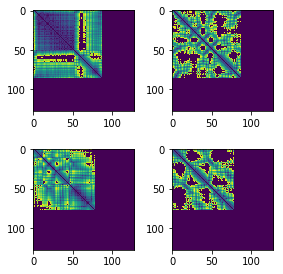

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(4,4))
for ax, d0, d1, dim in zip(axs, data[0], data[1][0], data[-1]):
    ax[0].imshow( d0[0, :, :].cpu().numpy() )
    ax[1].imshow( d1[:, :, :].argmax(-1).cpu().numpy() )
plt.tight_layout()

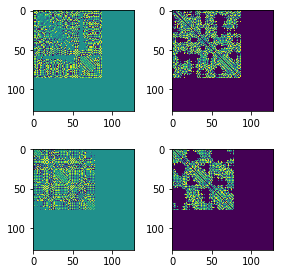

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(4,4))
for ax, d0, d1 in zip(axs, data[0], data[1][1]):
    ax[0].imshow( d0[1, :, :].cpu().numpy() )
    ax[1].imshow( d1[:, :].argmax(-1).cpu().numpy() )
plt.tight_layout()

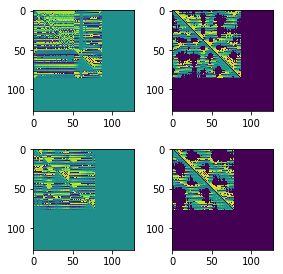

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(4,4))
for ax, d0, d1 in zip(axs, data[0], data[1][2]):
    ax[0].imshow( d0[2, :, :].cpu().numpy() )
    ax[1].imshow( d1[:, :].argmax(-1).cpu().numpy() )
plt.tight_layout()

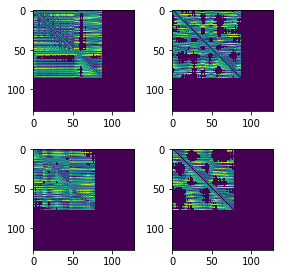

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(4,4))
for ax, d0, d1 in zip(axs, data[0], data[1][3]):
    ax[0].imshow( d0[3, :, :].cpu().numpy() )
    ax[1].imshow( d1[:, :].argmax(-1).cpu().numpy() )
plt.tight_layout()

## 3. Train

In [24]:
from genesis.source.utils import loss_function, train, evaluate_loss, get_lr

In [27]:
# lower the learning rate
for param_group in optimizer.param_groups:
    print('old lr: {}'.format(param_group['lr'])) # old lr: 2.2642685068943414e-06
    
    # cooling
    #param_group['lr'] *= 0.1
    
    # heating
    param_group['lr'] *= 10
    
    print('current lr: {}'.format(param_group['lr']))

old lr: 0.00016080666902157663
current lr: 0.0016080666902157663


In [ ]:
from torch.utils.tensorboard import SummaryWriter

output_folder = './trajectories/'

if do_training == True:
    os.makedirs(output_folder, exist_ok=True)
    chkpt_path = os.path.join(output_folder, 'checkpoint_{}')
    writer     = SummaryWriter(log_dir=os.path.join(output_folder, 'runs/'))
    epoch      = 0
    
if do_training == 'resume':
    checkpoint      = torch.load('./trajectories/checkpoint_500', map_location=torch.device(device))
    epoch           = checkpoint['epoch']
    train_loss_mean = checkpoint['loss']
    model1.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    chkpt_path = output_folder+'/checkpoint_{}'
    writer     = SummaryWriter(log_dir=os.path.join(output_folder, 'runs/'))
    print('resume training at epoch {}'.format(epoch))

if do_training == 'resume' or do_training == True:
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t_start = time.perf_counter()
    
    dtr = {'epoch': [], 'train_loss': [], 'test_loss': []}
    for epoch in range(epoch + 1, epochs):
        # Train
        train_loss_mean, train_loss_std, train_reprod_loss_mean = train(model1, 
                                                                        optimizer,  
                                                                        loss_function, 
                                                                        train_loader)
        test_loss_mean,  test_loss_std, test_reprod_loss_mean  = evaluate_loss(model1, 
                                                                               loss_function, 
                                                                               test_loader)   
        
        # adjust learning rate
        if epoch%2==0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= .97

        # Log to tensorboard
        writer.add_scalar('train/train_reprod_loss_mean', train_reprod_loss_mean, epoch)
        writer.add_scalar('test/test_reprod_loss_mean',   test_reprod_loss_mean,  epoch)  
        writer.add_scalar('train/train_loss_mean', train_loss_mean, epoch)
        writer.add_scalar('test/test_loss_mean',   test_loss_mean,  epoch)  

        # Timer
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t_end         = time.perf_counter()
        duration      = torch.tensor(t_end - t_start)
        duration_mean = duration.mean().item()
        
        if epoch%10==0:
            torch.save( {'epoch': epoch, 'model_state_dict': model1.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(), 'loss': train_loss_mean}, 
                          chkpt_path.format(epoch) )

        print('epoch {} {:.3f}, train loss: {:10.9f}, lr: {:.9f}, test loss: {:10.5f}'.format(
            epoch, duration_mean / 60, train_loss_mean, get_lr(optimizer), test_loss_mean))
        
        dtr['epoch'].append(epoch)
        dtr['train_loss'].append(train_loss_mean.item())
        dtr['test_loss'].append(test_loss_mean.item())
        
else:
    checkpoint = torch.load('./trajectories/checkpoint_500', map_location=torch.device(device))
    epoch = checkpoint['epoch']
    train_loss_mean = checkpoint['loss']
    model1.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print('epoch {}, train loss: {:10.9f}'.format(epoch, train_loss_mean))

epoch 1 2.072, train loss: 1656.600097656, lr: 0.001608067, test loss: 1667.25708
epoch 2 4.138, train loss: 1483.193969727, lr: 0.001559825, test loss: 1630.60706
epoch 3 6.204, train loss: 1419.152587891, lr: 0.001559825, test loss: 1632.23193
epoch 4 8.269, train loss: 1382.048583984, lr: 0.001513030, test loss: 1626.71472
epoch 5 10.336, train loss: 1354.627929688, lr: 0.001513030, test loss: 1609.22412
epoch 6 12.401, train loss: 1334.779052734, lr: 0.001467639, test loss: 1622.66772
epoch 7 14.467, train loss: 1318.151123047, lr: 0.001467639, test loss: 1614.56470
epoch 8 16.533, train loss: 1304.896484375, lr: 0.001423610, test loss: 1605.63928
epoch 9 18.599, train loss: 1293.806030273, lr: 0.001423610, test loss: 1604.37012
epoch 10 20.666, train loss: 1283.930297852, lr: 0.001380902, test loss: 1603.85071
epoch 11 22.735, train loss: 1275.140502930, lr: 0.001380902, test loss: 1605.75378
epoch 12 24.801, train loss: 1268.036376953, lr: 0.001339475, test loss: 1595.06506
epoch

epoch 101 208.674, train loss: 1137.844360352, lr: 0.000350664, test loss: 1584.36279
epoch 102 210.739, train loss: 1137.422363281, lr: 0.000340144, test loss: 1589.38989
epoch 103 212.803, train loss: 1137.380249023, lr: 0.000340144, test loss: 1584.87207
epoch 104 214.867, train loss: 1136.714355469, lr: 0.000329939, test loss: 1587.80859
epoch 105 216.932, train loss: 1136.192749023, lr: 0.000329939, test loss: 1582.21753
epoch 106 218.995, train loss: 1135.891357422, lr: 0.000320041, test loss: 1586.82031
epoch 107 221.059, train loss: 1135.764648438, lr: 0.000320041, test loss: 1589.35791
epoch 108 223.123, train loss: 1135.437866211, lr: 0.000310440, test loss: 1591.89478
epoch 109 225.187, train loss: 1135.221801758, lr: 0.000310440, test loss: 1591.22424
epoch 110 227.251, train loss: 1134.981811523, lr: 0.000301127, test loss: 1581.35693
epoch 111 229.318, train loss: 1134.653198242, lr: 0.000301127, test loss: 1579.80530
epoch 112 231.382, train loss: 1134.094970703, lr: 0.0

epoch 197 406.850, train loss: 1121.676147461, lr: 0.000081271, test loss: 1584.61584
epoch 198 408.914, train loss: 1121.538574219, lr: 0.000078833, test loss: 1590.12317
epoch 199 410.978, train loss: 1121.457641602, lr: 0.000078833, test loss: 1587.82947
epoch 200 413.042, train loss: 1121.480957031, lr: 0.000076468, test loss: 1584.76697
epoch 201 415.109, train loss: 1121.559936523, lr: 0.000076468, test loss: 1584.72498
epoch 202 417.173, train loss: 1121.165649414, lr: 0.000074174, test loss: 1581.40430
epoch 203 419.237, train loss: 1121.033569336, lr: 0.000074174, test loss: 1589.46277
epoch 204 421.301, train loss: 1121.169311523, lr: 0.000071948, test loss: 1579.82507
epoch 205 423.366, train loss: 1121.036987305, lr: 0.000071948, test loss: 1583.08862
epoch 206 425.430, train loss: 1121.051757812, lr: 0.000069790, test loss: 1584.46985
epoch 207 427.494, train loss: 1121.052124023, lr: 0.000069790, test loss: 1580.10474
epoch 208 429.559, train loss: 1120.890869141, lr: 0.0